# Notas sobre procesamiento digital de señales aplicado al análisis de vibraciones mecánicas

## Elaborado por Mag. Luis Sánchez Céspedes

In [2]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft
from scipy import signal

np.random.seed(1)
plt.style.use('classic')

In [3]:
def get_frequency_domain(series):
    series_fft = abs(np.fft.fft(series))
    series_fft_half = series_fft[0:int(len(series)//2)]

    return series_fft_half

def load_data(file_path="") -> str:
    input_data = np.genfromtxt(file_path, delimiter=",")
    thisdict = {}
    thisdict['input_data'] = {"data":input_data.tolist()}
    return json.dumps(thisdict)

def get_hilbert_transform(data):
    n = len(data)
    X = fft(data)
    H = np.zeros(n)

    if n % 2 == 0:
        H[0]=1
        H[1:n//2]=2
    else:
        H[0]=1
        H[1:(n+1)//2]=2

    H[(n//2)+1:]=0
    X_hat = X * H

    return ifft(X_hat)

def get_analytic_signal(data):
    return data + 1j * get_hilbert_transform(data)

def get_amplitude_envelope(analytic_signal):
    return np.abs(analytic_signal)

def get_instantaneous_phase(analytic_signal):
    return np.angle(analytic_signal)

def get_intantaneous_frequency(instantaneous_phase, sampling_rate=50000):
    return np.diff(instantaneous_phase)*(sampling_rate/(2.0*np.pi))

# 1. Transformada Discreta de Fourier (DFT)

La Transformada Discreta de Fourier en su forma exponencial se define como

$$
\begin{align}
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i2\pi\frac{n}{N}}
\end{align}
$$

- La frecuencia es discreta, finita y está representada por la letra k
- El tiempo es discreto, finito y está representado por la letra n

Gracias a la formula de Euler

$$
\begin{align}
e^{i\theta} = \cos\theta + i\sin\theta
\end{align}
$$

Podemos representar DFT en forma polar

$$
\begin{align}
X_k = \sum_{n=0}^{N-1} x_n [\cos{i2\pi\frac{n}{N}} -i\sin{2\pi\frac{n}{N}}]
\end{align}
$$

Donde la parte real es

$$
\begin{align}
Re_{X_k} = \sum_{n=0}^{N-1} x_n [\cos{i2\pi\frac{n}{N}}]
\end{align}
$$

Y la imaginaria es

$$
\begin{align}
Im_{X_k} = \sum_{n=0}^{N-1} x_n [-i\sin{2\pi\frac{n}{N}}]
\end{align}
$$


## Ejemplo simple

In [53]:
def get_wave(frequency, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate*duration, endpoint=False)
    frequencies = x * frequency
    y = np.sin((2*np.pi)*frequencies)

    return x, y

Text(0.5, 0, 'Time (s)')

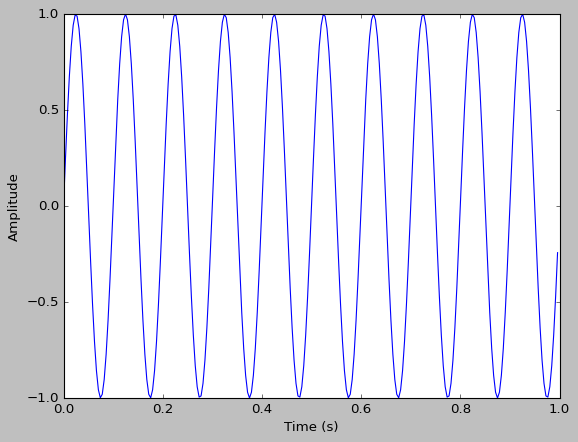

In [71]:
frequency = 10 #Hz
sample_rate = 256 #samples per second
duration = 1 # second

x, y = get_wave(frequency, sample_rate, duration)
plt.plot(x,y)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

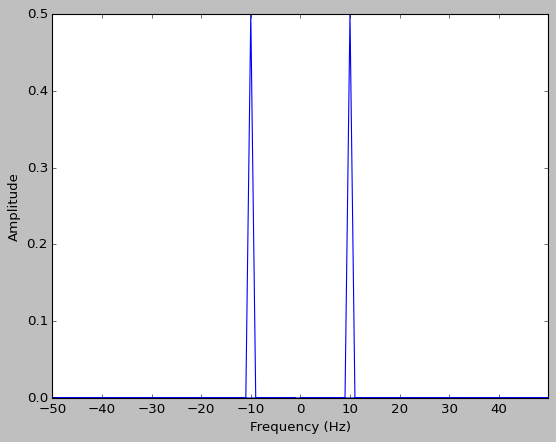

In [83]:
plt.plot(np.fft.fftfreq(sample_rate, d=1/sample_rate), abs(np.fft.fft(y))/256)
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.xlim(-50,50)
plt.xticks(range(-50,50, 10));

- Es importante notar la frecuencia negativa.

In [63]:
file_path = 'D:\\Datos\\full\\underhang\\ball_fault\\0g\\13.1072.csv'
input_data = np.genfromtxt(file_path, delimiter=",")
data = input_data[:,7][:50000]
raw_fft = np.fft.fft(data)
raw_freq = np.fft.fftfreq(data.shape[0], d=1/data.shape[0])

Text(0.5, 0, 'Time (s)')

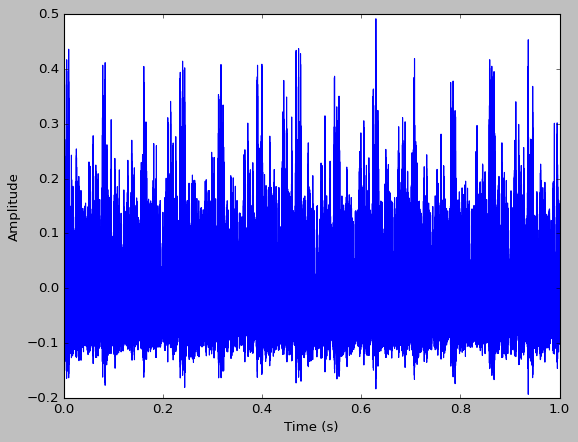

In [68]:
plt.plot(np.linspace(0, 1, 50000), data)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Frequency (Hz)')

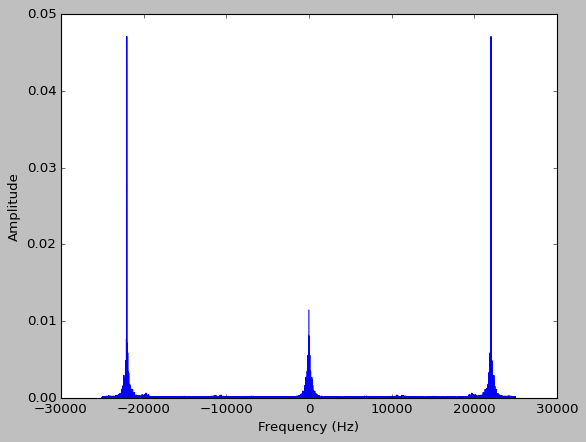

In [70]:
plt.plot(raw_freq, abs(raw_fft)/data.shape[0])
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')

## 1.1. Aliasing

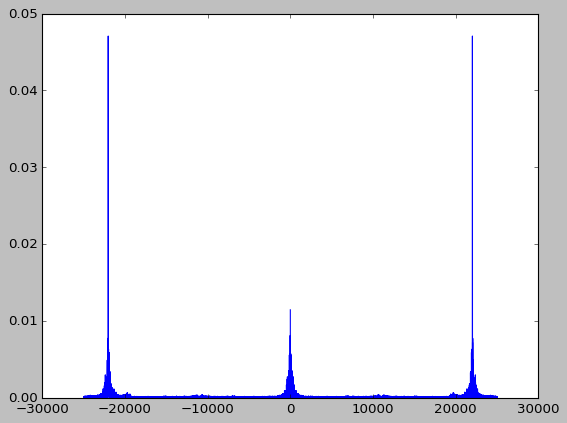

In [13]:
plt.plot(raw_freq, abs(raw_fft)/data.shape[0])

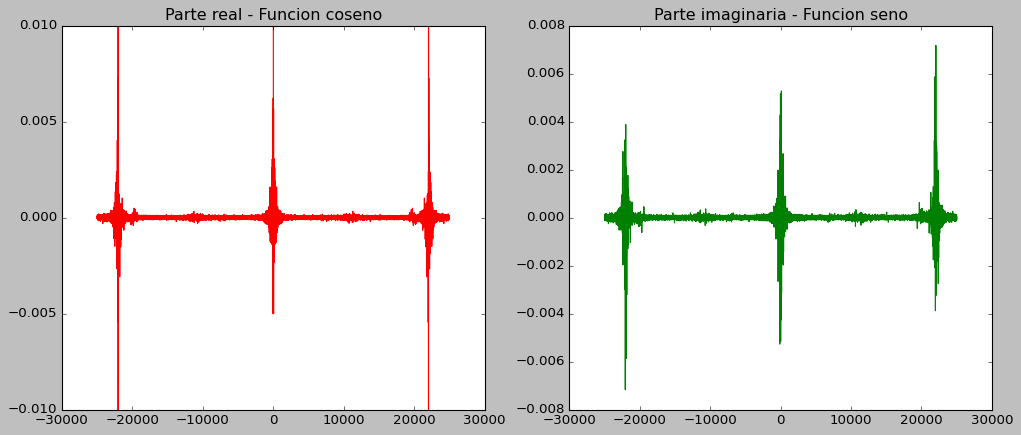

In [14]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
axis[0].plot(raw_freq, raw_fft.real/data.shape[0], 'r')
axis[0].set_ylim([-0.01, 0.01])
axis[0].set_title("Parte real - Funcion coseno")

axis[1].plot(raw_freq, raw_fft.imag/data.shape[0], 'g')
axis[1].set_title("Parte imaginaria - Funcion seno")
plt.show() 

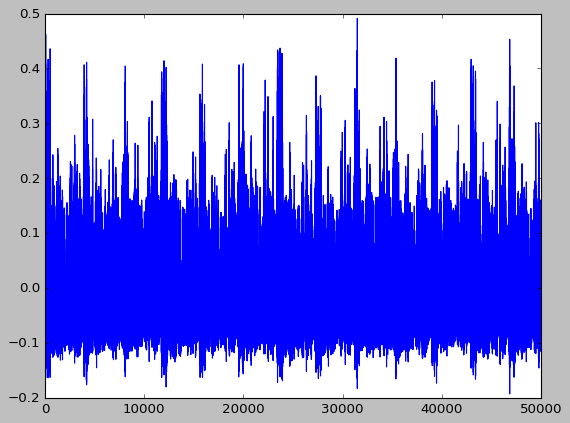

In [15]:
plt.plot(data)

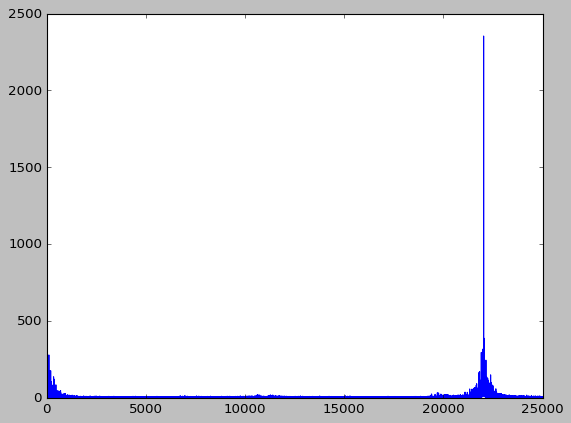

In [16]:
plt.plot(signal_fft)

# 2. Transformada de Hilbert

 $$
 \begin{align}
  H({\omega}) =
    \begin{cases}
      1, & \omega > 0\\
      0, & \omega = 0\\
      -1, & \omega < 0
    \end{cases}       
\end{align}
$$

Numericamente y usando la transforma discreta de Fourier se aproxima la transformada de Hilbert con los siguientes valores

 $$
 \begin{align}
  H({\omega}) =
    \begin{cases}
      2, & \omega > 0\\
      0, & \omega = 0\\
      1, & \omega < 0
    \end{cases}       
\end{align}
$$

In [17]:
raw_signal = get_hilbert_transform(data)

c:\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


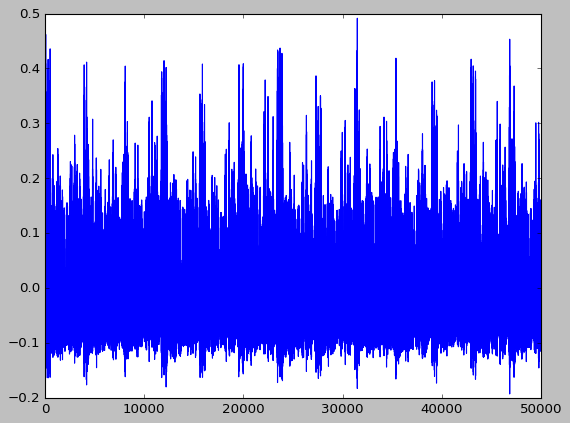

In [18]:
plt.plot(raw_signal)

In [19]:
raw_analytic_signal = get_analytic_signal(data)
envelope = get_amplitude_envelope(raw_analytic_signal)
ip = get_instantaneous_phase(raw_analytic_signal)
ifreq = get_intantaneous_frequency(ip)

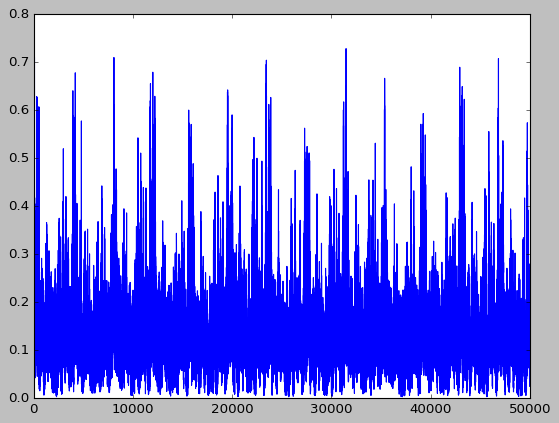

In [20]:
plt.plot(envelope)

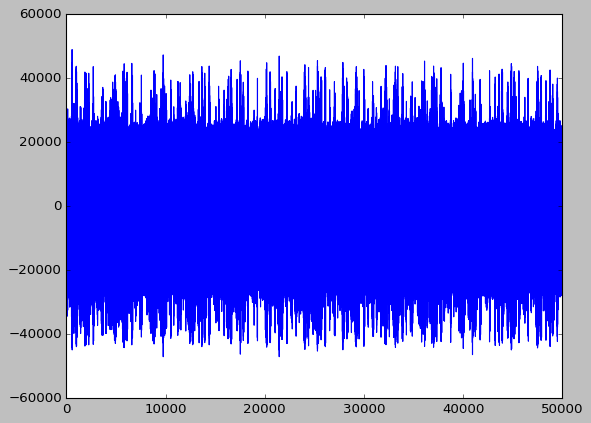

In [21]:
plt.plot(ifreq)

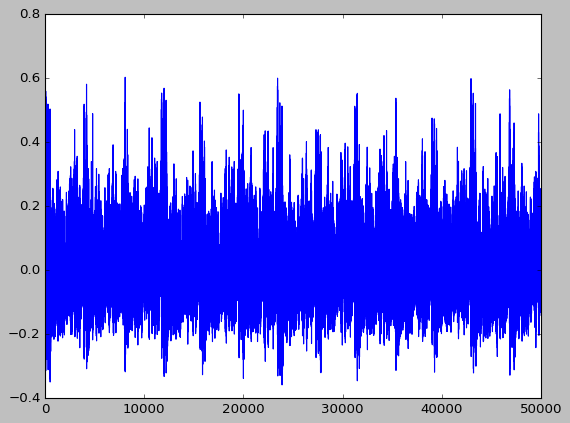

In [22]:
plt.plot(raw_analytic_signal)

# 3. Señal Analítica (Análisis de envolvente)

La señal analítica se define como

$$
\begin{align}
z(t) = s(t) + i \hat{s}(t)
\end{align}
$$

Donde $\hat{s}$ es la transformada de Hilbert

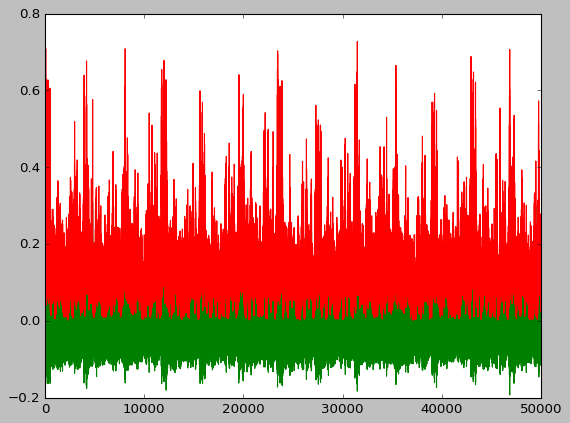

In [23]:
plt.plot(data, 'g')
plt.plot(envelope, 'r')

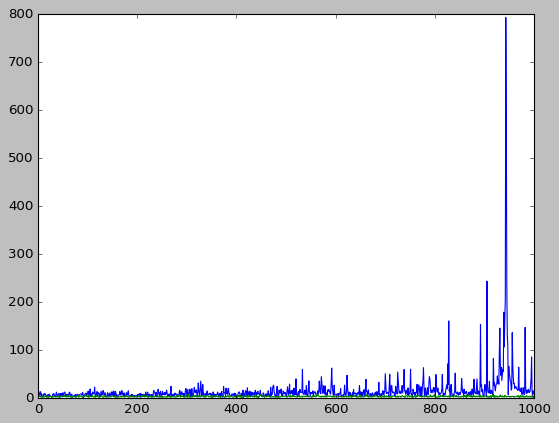

In [24]:
plt.plot(get_frequency_domain(envelope)[5000:6000])
plt.plot(signal_fft[5000:6000])

In [25]:
time = np.linspace(0,1,500, endpoint=False)
sampling_rate = 500
raw_signal = np.sin(2*np.pi*50*time) 
raw_signal = np.sin(2*np.pi*50*time) + 0.5*np.random.randn(500)

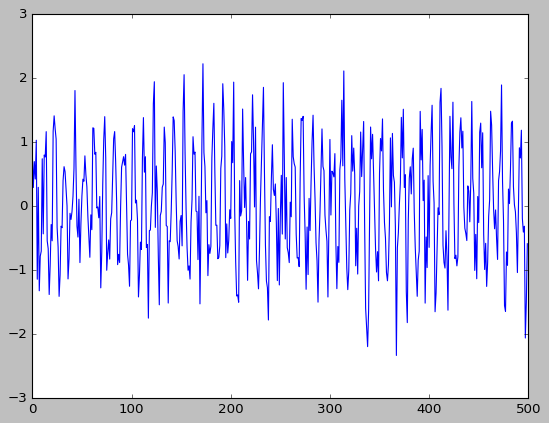

In [26]:
plt.plot(raw_signal)

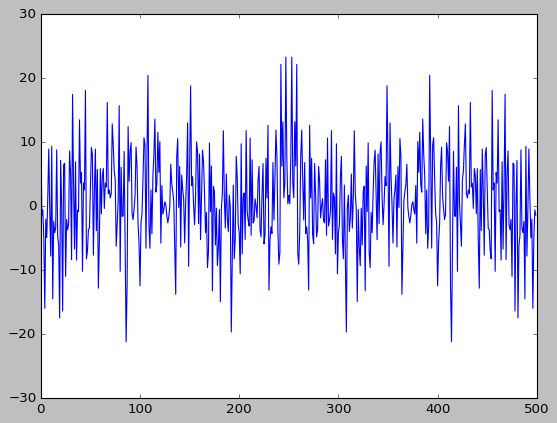

In [27]:
plt.plot(np.fft.fft(raw_signal))

In [28]:
b,a = signal.butter(3, [40, 60], btype='bandpass', fs=sampling_rate)
filtered_signal = signal.lfilter(b, a, raw_signal)

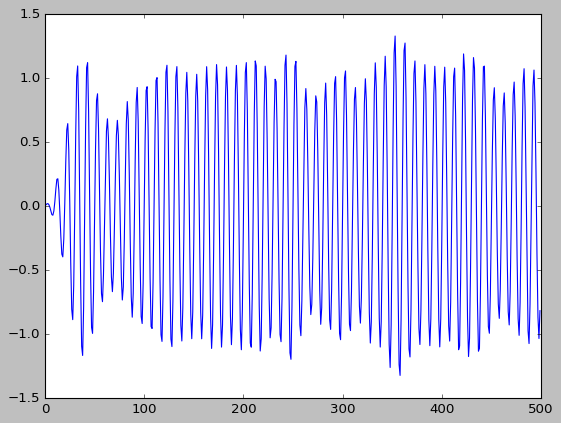

In [29]:
plt.plot(filtered_signal)

In [30]:
raw_analytic_signal = get_analytic_signal(raw_signal)
envelope = get_amplitude_envelope(raw_analytic_signal)
ip = get_instantaneous_phase(raw_analytic_signal)
ifreq = get_intantaneous_frequency(ip)

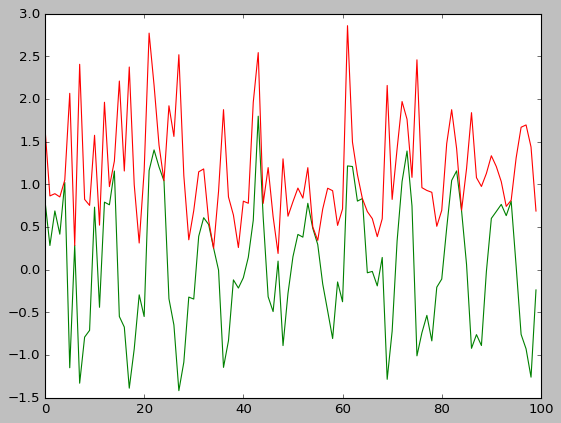

In [31]:
plt.plot(raw_signal[0:100], 'g')
plt.plot(envelope[0:100], 'r')